In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

In [11]:
def load_benchmark(pattern, skip_warmup=10, zscore_threshold=2.5):
    frames = []
    for path in sorted(glob.glob(pattern)):
        df = pd.read_csv(path).iloc[skip_warmup:]
        frames.append(df)

    df = pd.concat(frames, ignore_index=True)

    def drop_outliers(group):
        for col in group.select_dtypes(include=np.number).columns:
            if col == 'sphere_count': continue
            z = np.abs((group[col] - group[col].mean()) / (group[col].std() + 1e-9))
            group = group[z < zscore_threshold]
        return group

    df = df.groupby('sphere_count', group_keys=False).apply(drop_outliers)
    return df.groupby('sphere_count').mean(numeric_only=True)

epipolar = load_benchmark('C:\\Users\\liamc\\Downloads\\*epipolar_benchmark.csv')
physics  = load_benchmark('C:\\Users\\liamc\\Downloads\\*physics_benchmark.csv')

epipolar['speedup'] = epipolar['cpu_compute_ms'] / epipolar['gpu_compute_ms']
physics['speedup']  = physics['cpu_physics_ms']  / physics['gpu_physics_ms']

print(epipolar[['gpu_compute_ms', 'cpu_compute_ms', 'speedup']].round(3))
print(physics[['gpu_physics_ms', 'cpu_physics_ms', 'speedup']].round(3))

              gpu_compute_ms  cpu_compute_ms  speedup
sphere_count                                         
3                      0.023           0.654   28.471
10                     0.044           0.976   22.184
25                     0.091           1.482   16.358
50                     0.168           2.363   14.068
75                     0.243           3.083   12.712
100                    0.320           4.005   12.515
250                    0.999           9.170    9.182
500                    1.810          17.216    9.511
750                    2.619          25.846    9.869
1000                   3.408          33.940    9.960
1250                   4.417          41.167    9.321
1500                   5.060          50.162    9.913
2000                   7.004          66.424    9.483
2500                   8.409          81.754    9.722
3000                  10.393          98.443    9.472
3500                  11.478         114.839   10.005
3750                  11.923

C:\Users\liamc\AppData\Local\Temp\ipykernel_19056\2501868797.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('sphere_count', group_keys=False).apply(drop_outliers)
C:\Users\liamc\AppData\Local\Temp\ipykernel_19056\2501868797.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('sphere_count', group_keys=False).apply(drop_outliers)


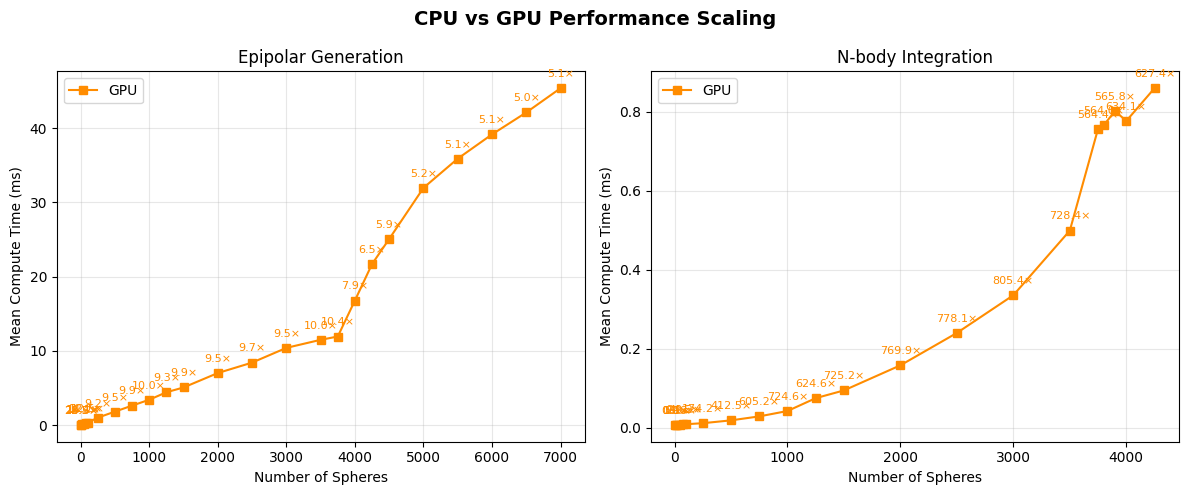

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('CPU vs GPU Performance Scaling', fontsize=14, fontweight='bold')

for ax, df, gpu_col, cpu_col, title in [
    (axes[0], epipolar, 'gpu_compute_ms', 'cpu_compute_ms', 'Epipolar Generation'),
    (axes[1], physics,  'gpu_physics_ms', 'cpu_physics_ms', 'N-body Integration'),
]:
    #ax.plot(df.index, df[cpu_col], 'o-', label='CPU', color='steelblue')
    ax.plot(df.index, df[gpu_col], 's-', label='GPU', color='darkorange')
    ax.set_title(title)
    ax.set_xlabel('Number of Spheres')
    ax.set_ylabel('Mean Compute Time (ms)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    for n in df.index:
        ax.annotate(f'{df.loc[n, "speedup"]:.1f}×',
                    xy=(n, df.loc[n, gpu_col]),
                    xytext=(0, 8), textcoords='offset points',
                    ha='center', fontsize=8, color='darkorange')

plt.tight_layout()
plt.savefig('benchmark_plot.png', dpi=150, bbox_inches='tight')
plt.show()